In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import matplotlib.transforms as transforms
%matplotlib inline
import seaborn as sns

import wordcloud 
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 500

In [2]:
# import data
data = pd.read_csv('.../mass_shooting/5.csv', encoding='ISO-8859-1')

# rename & clean columns for easier manipulation
data.columns = ['s', 'title', 'location', 'date', 'area', 'o_c', 'target', 'cause', 'summary', 'v_fatalities', 'v_injured', 'v_tot', 'v_police', 'age', 'employed', 'employed_loc', 'mental_health', 'race', 'gender', 'lat', 'lon']
data = data.drop(['s', 'area', 'o_c', 'employed_loc'], axis=1)

# explore
data.head(3)

,title,location,date,target,cause,summary,v_fatalities,v_injured,v_tot,v_police,age,employed,mental_health,race,gender,lat,lon
0,Texas church mass shooting,"Sutherland Springs, TX",11/5/2017,random,unknown,"Devin Patrick Kelley, 26, an ex-air force offi...",26,20,46,0.0,26,NaN,No,White,M,NaN,NaN
1,Walmart shooting in suburban Denver,"Thornton, CO",11/1/2017,random,unknown,"Scott Allen Ostrem, 47, walked into a Walmart ...",3,0,3,0.0,47,NaN,No,White,M,NaN,NaN
2,Edgewood businees park shooting,"Edgewood, MD",10/18/2017,coworkers,unknown,"Radee Labeeb Prince, 37, fatally shot three pe...",3,3,6,0.0,37,NaN,No,Black,M,NaN,NaN


In [3]:
# examine data types
data.dtypes

title             object
location          object
date              object
target            object
cause             object
summary           object
v_fatalities       int64
v_injured          int64
v_tot              int64
v_police         float64
age               object
employed         float64
mental_health     object
race              object
gender            object
lat              float64
lon              float64
dtype: object

In [4]:
# examine outputs
print(data['target'].sort_values().unique())
print(data['cause'].sort_values().unique())
print(data['age'].sort_values().unique())
print(data['mental_health'].sort_values().unique())
print(data['race'].sort_values().unique())
print(data['gender'].sort_values().unique())

['Children' 'Congresswoman' 'Contestant' "Coworker's Family" 'Coworkers'
 'Ex-Coworkers' 'Ex-GirlFriend' 'Ex-Girlfriend' 'Ex-Girlfriend & Family'
 'Ex-Girlfriend+random' 'Ex-Wife' 'Ex-Wife & Family' 'Ex-girlfriend'
 'Family' 'Family+random' 'Family+students' 'Family/Neighbors' 'Friends'
 'Girlfriend' 'House Owner' 'Marines' 'Policeman'
 'Policeman+Council Member' 'Sikhs' 'Social Workers' 'Students'
 'Students+Parents' 'Students+Teachers' 'TSA Officer' 'Teachers' 'Trooper'
 'basketball players' 'birthday party bus' 'black men' 'club members'
 'coworkers' 'drug dealer' 'hunters' 'lawyers' 'monks' 'neighbors'
 "partner's family" 'party guests' 'police' 'postmaster' 'prayer group'
 'protestors' 'psychologist+psychiatrist' 'random' 'rapper+random'
 'school girls' 'uninvited guests' 'welding shop employees' 'women' nan]
['anger' 'breakup' 'domestic dispute' 'domestic disputer' 'drunk'
 'failing exams' 'frustration' 'psycho' 'racism' 'religious radicalism'
 'revenge' 'robbery' 'suspension' 't

In [5]:
# clean 

data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')

# For easier manipulation, convert age to a single value 'Other'
# Also change age value '0' to 'Other
# Will change age to numeric later

data = data.replace({'age' : {'19,32' : 'Other',
                              '19,22' : 'Other',
                              '17,18' : 'Other',
                              '13,11' : 'Other',
                              '15,16' : 'Other',
                              '0' : 'Other'
                             }})

data = data.replace({'target': {'rapper+random': 'random',
                                      'Girlfriend': 'women',
                                      'Ex-GirlFriend': 'Ex-girlfriend',
                                      'Ex-Girlfriend': 'Ex-girlfriend',
                                      'Ex-Girlfriend+random': 'Ex-girlfriend',
                                      'Ex-Girlfriend & Family': 'Ex-girlfriend',
                                      'Ex-Wife & Family': 'Ex-Wife',
                                      'coworkers': 'Coworkers',
                                      'Coworker\'s Family': 'Coworkers',
                                      'Family+students': 'Family+random',
                                      'school girls': 'Children'
                                     },
                    'cause' : {'domestic disputer' : 'domestic dispute'
                              },
                    'mental_health' : {'Unclear' : 'Unknown',
                                       'unknown' : 'Unknown'
                                      },
                    'race' : {'White American or European American' : 'White',
                              'white' : 'White',
                              'Black American or African American' : 'Black',
                              'Some other race' : 'Unknown',
                              'Asian American' : 'Asian',
                              'black': 'Black',
                              'Two or more races' : 'Other',
                              'Asian American/Some other race' : 'Other',
                              'White American or European American/Some other Race' : 'Other',
                              'Black American or African American/Unknown' : 'Other',
                              'Native American or Alaska Native' : 'Native American'
                             },
                     'gender' : {'M' : 'Male',
                                 'M/F' : 'Unknown'
                                }
                    })

## Exploratory Data Analysis - Datetime

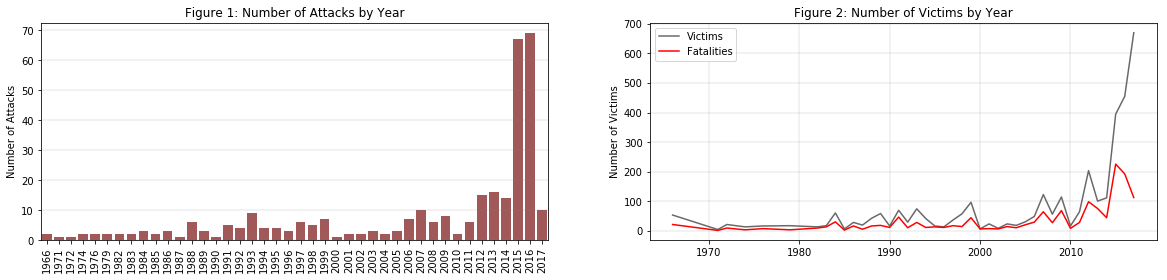

In [6]:
# group by yearly attacks, victims, fatalities
data['year'] = data['date'].dt.year
yearly_attacks = data['year'].value_counts()

yearly_victims = data.groupby(['year']).sum()['v_tot']
yearly_fatalities = data.groupby(['year']).sum()['v_fatalities']

# plot 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))

ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

#ax1.bar(yearly_attacks.index, yearly_attacks.values, color='DarkRed')
#ax1.set(xlabel='', ylabel='Number of Attacks')
#ax1.set_title('Figure 3: Number of Mass Shootings in U.S. by Year')

ax1 = sns.barplot(yearly_attacks.index, yearly_attacks.values, color='DarkRed', alpha=0.7, ax=ax1)
ax1.set(xlabel='', ylabel='Number of Attacks')
xrotate = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Figure 1: Number of Attacks by Year')

ax2.plot(yearly_victims, color='DimGrey')
ax2.plot(yearly_fatalities, color='Red')
ax2.legend(['Victims', 'Fatalities'], loc='upper left')
ax2.set(xlabel='', ylabel='Number of Victims')
ax2.set_title('Figure 2: Number of Victims by Year')

plt.show()

- Number of attacks spiked in 2015, jumping from 14 in 2014 to 67 in 2015. This upward trend continued in 2016, with 69 recorded attacks. 
- The dataset's latest recorded attack is dated at November 5, 2017. Since it's close to the end of the calendar year, we can say to a certain degree that the number of attacks dropped significantly in 2017.

For future investigations, it would be interesting to examine any regulatory/policy changes that occured in 2016/2017 that may have motivated this drop.

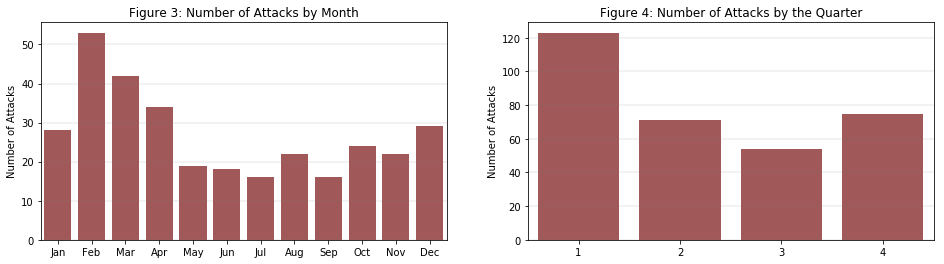

In [7]:
# group by monthly and quarterly
data['month'] = data['date'].dt.month
monthly_attacks = data['month'].value_counts()

data['quarter'] = data['date'].dt.quarter
quarterly_attacks = data['quarter'].value_counts()

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

l1 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1 = sns.barplot(monthly_attacks.index, monthly_attacks.values, color='DarkRed', alpha=0.7, ax=ax1)
lab1 = ax1.set_xticklabels(l1)
ax1.set(xlabel='', ylabel='Number of Attacks')
ax1.set_title('Figure 3: Number of Attacks by Month')

ax2 = sns.barplot(quarterly_attacks.index, quarterly_attacks.values, color='DarkRed', alpha=0.7, ax=ax2)
ax2.set(xlabel='', ylabel='Number of Attacks')
dum = ax2.set_title('Figure 4: Number of Attacks by the Quarter')

- The 1st quarter tends to observe the highest number of shootings, nearly double the number of attacks observed in other quarters. Of this, February and March recorded the highest number of attacks. 
- The 3rd quarter observed the lowest number of attacks, although the difference between 3rd, 2nd, and 4th are not significant.

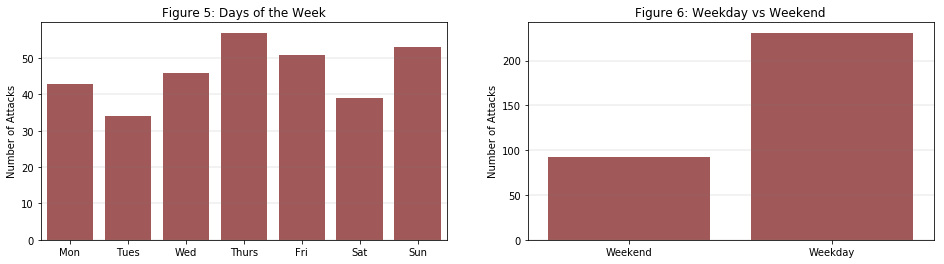

In [8]:
# calculate weekday vs weekend
data['day'] = data['date'].dt.dayofweek
daily_attacks = data['day'].value_counts()

data['weekday'] = (data['day']//5 != 1).astype(int)
weekday = data['weekday'].value_counts()

l1 = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
l2 = ['Weekend', 'Weekday']

# plot 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax1 = sns.barplot(daily_attacks.index, daily_attacks.values, color='DarkRed', alpha=0.7, ax=ax1)
ax1.set(xlabel='', ylabel='Number of Attacks')
ax1.set_xticklabels(l1)
ax1.set_title('Figure 5: Days of the Week')

ax2 = sns.barplot(weekday.index, weekday.values, color='DarkRed', alpha=0.7, ax=ax2)
lab2 = ax2.set_xticklabels(l2)
ax2.set(xlabel='', ylabel='Number of Attacks')
dum = ax2.set_title('Figure 6: Weekday vs Weekend')

## Exploratory Data Analysis - Other Factors


*Figure 8: Male/Female indicates two perpetrators (male and female)


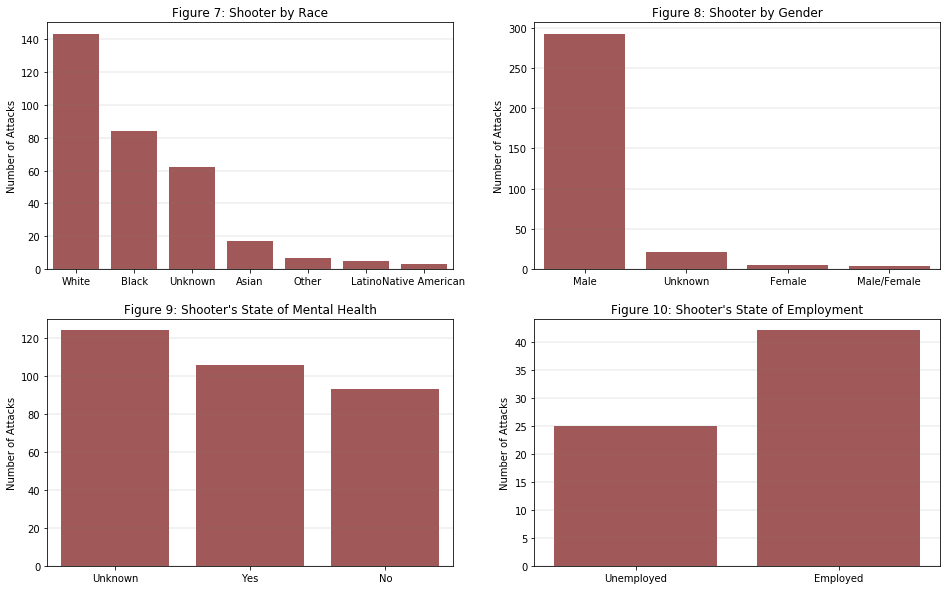

In [9]:
race = data['race'].value_counts()
gender = data['gender'].value_counts()
mental_health = data['mental_health'].value_counts()
employed = data['employed'].value_counts()

# plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.grid(color='grey', linestyle='-', linewidth=0.2)
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

ax0 = sns.barplot(race.index, race.values, color='DarkRed', alpha=0.7, ax=ax0)
ax0.set_title('Figure 7: Shooter by Race')
ax0.set(xlabel='', ylabel='Number of Attacks')

ax1 = sns.barplot(gender.index, gender.values, color='DarkRed', alpha=0.7, ax=ax1)
ax1.set_title('Figure 8: Shooter by Gender')
ax1.set(xlabel='', ylabel='Number of Attacks')
print('\n*Figure 8: Male/Female indicates two perpetrators (male and female)')

ax2 = sns.barplot(mental_health.index, mental_health.values, color='DarkRed', alpha=0.7, ax=ax2)
ax2.set_title('Figure 9: Shooter\'s State of Mental Health')
ax2.set(xlabel='', ylabel='Number of Attacks')

ax3 = sns.barplot(employed.index, employed.values, color='DarkRed', alpha=0.7, ax=ax3)
labels = ['Unemployed', 'Employed']
ax3.set_title('Figure 10: Shooter\'s State of Employment')
ax3.set_xticklabels(labels)
ax3.set(xlabel='', ylabel='Number of Attacks')

plt.show()

- Incidents involving a white shooter is nearly 175% higher than incidents perpetrated by a black shooter 
- Males are the leading perpetrators; of the 323 total incidents, 292 were caused by a lone male shooter
- The state of mental health is unclear; where known, the difference doesn't seem to be statistically significant 
- Nearly twice as much shooters were employed at the time of the incident

## Exploratory Data Analysis - Textual Analysis

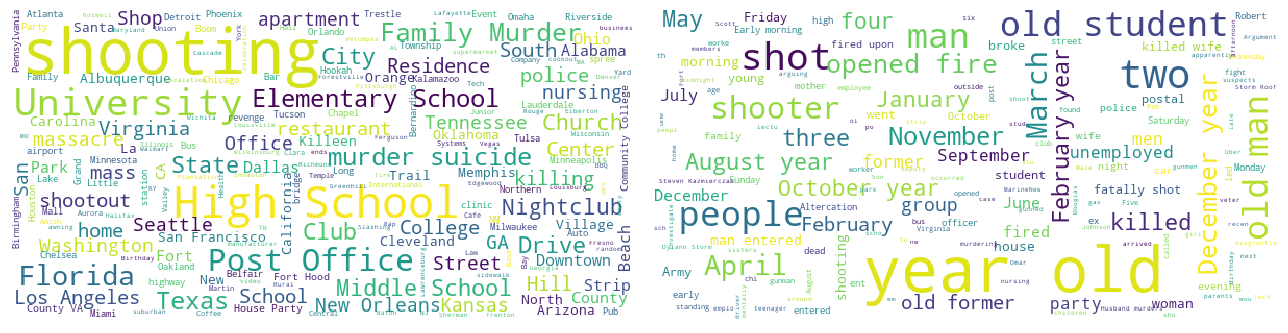

In [10]:
f, axarr = plt.subplots(1,2, figsize=(18,15))

cloud1 = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=40,
    scale=1.5
    ).generate(str(data['title']))

axarr[0].imshow(cloud1)
axarr[0].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
axarr[0].tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
axarr[0].axis('off')

cloud2 = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=40,
    scale=1.5
    ).generate(str(data['summary']))

axarr[1].imshow(cloud2)
axarr[1].tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
axarr[1].tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
axarr[1].axis('off')

plt.tight_layout()
plt.show()

Textual analysis can help narrow down the analytic focus. On the left side is a cloud generated with the dataset's `title` column, and on the right is a cloud made with `summary` column. Both are text-heavy categories.

The `summary` column doesn't really tell us much, but the `title` column gives gives some clues for categorizing and better understanding the nature of the incidents in our dataset. Several words stand out: 
- School shootings: 'High School', 'University', 'Elementary School', 'Middle School', 'College', 'School'
- 'Post Office'
- 'Church'
- 'Nightclub'/'Club'

We also see several names of U.S. states and cities, and these will be examined in a later section.

In [11]:
# sort 
conditions = [
    (data['title'].str.contains('[Ss]chool|[Uu]niversity|[Cc]ollege')),
    (data['title'].str.contains('[Pp]ost [Oo]ffice|[Pp]ostal [Oo]ffice')),
    (data['title'].str.contains('[Nn]ightclub|[Cc]lub')),
    (data['title'].str.contains('[Cc]hurch'))]
choices = ['School', 'Post Office', 'Club', 'Church']
data['eda_location'] = np.select(conditions, choices, default='Other')

eda_location = data['eda_location'].value_counts()

school = data[data['eda_location'] == 'School']
school_count = school.groupby(['year']).size()

postal = data[data['eda_location'] == 'Post Office']
postal_count = postal.groupby(['year']).size()

club = data[data['eda_location'] == 'Club']
club_count = club.groupby(['year']).size()

church = data[data['eda_location'] == 'Church']
church_count = church.groupby(['year']).size()

others = data[data['eda_location'] == 'Other']
others_count = others.groupby(['year']).size()

In [12]:
# sort victim data
school_victims = school.groupby(['year']).sum()['v_tot']
club_victims = club.groupby(['year']).sum()['v_tot']
church_victims = church.groupby(['year']).sum()['v_tot']
postal_victims = postal.groupby(['year']).sum()['v_tot']
others_victims = others.groupby(['year']).sum()['v_tot']

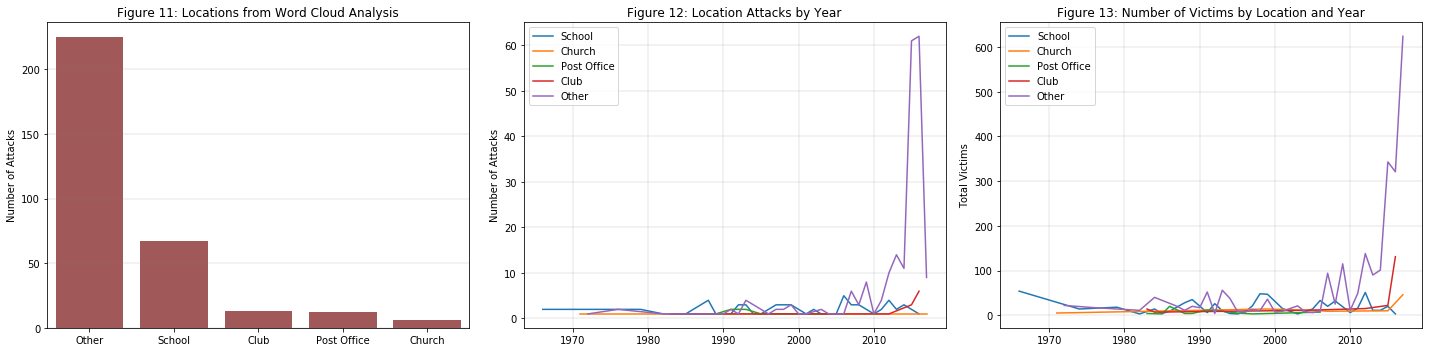

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
ax0, ax1, ax2 = axes.flatten()
ax0.grid(color='grey', linestyle='-', linewidth=0.2)
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax0 = sns.barplot(eda_location.index, eda_location.values, color='DarkRed', alpha=0.7, ax=ax0)
ax0.set(xlabel='', ylabel='Number of Attacks')
ax0.set_title('Figure 11: Locations from Word Cloud Analysis')

ax1.plot(school_count)
ax1.plot(church_count)
ax1.plot(postal_count)
ax1.plot(club_count)
ax1.plot(others_count)
ax1.set(xlabel='', ylabel='Number of Attacks')
dum = ax1.legend(['School', 'Church', 'Post Office', 'Club', 'Other'], loc='upper left')
dum = ax1.set_title('Figure 12: Location Attacks by Year')

ax2.plot(school_victims)
ax2.plot(church_victims)
ax2.plot(postal_victims)
ax2.plot(club_victims)
ax2.plot(others_victims)
ax2.set(xlabel='', ylabel='Total Victims')
dum = ax2.legend(['School', 'Church', 'Post Office', 'Club', 'Other'])
dum = ax2.set_title('Figure 13: Number of Victims by Location and Year')

plt.tight_layout()
plt.show()

- About 21% of all incidents in the dataset were school shootings, where 'school' is defined as occuring at or near universities, colleges, high schools, middle schools, or elementary schools (67 of 323 incidents).
- 13 of 323 incidents involved clubs.
- 12 of 323 incidents involved post offices.
- 6 of 323 incidents involved a church.
- The rest (69%) were comprised of non-distinct categories, and unsurprisingly involved the most number of victims that increased with the number of incidents. The number of incidents within this 'other' category have steadily increased over the years, with a sudden increase in recent years. Because of this huge spike, it's difficult to discern the datetime trend of other categories. 

In [14]:
# explore 'Other' category
data[data['eda_location'] == 'Other']['title'].sort_values().unique()

array(['Accent Signage Systems in Minneapolis',
       'Alabama highway random shooting', 'Albuquerque Auto Shop',
       'Albuquerque, NM Family restaurant shooting',
       'Albuquerque, NM House party shooting',
       'Amnicola Training Center, Chattanooga',
       'Annual motorcycle event in Newark', 'Arizona Family Murder',
       'Atlantis Plastics', 'Aurora theater shooting',
       'Azana Spa in Brookfield', 'Baton Rouge police shooting',
       'Belfair, WA Family murder-suicide', 'Belfair, Washington',
       'Binghamton shootings', 'Birchwood, Wisconsin',
       "Birmingham's Washington Park", 'Boom Boom Room',
       'Bourbon Street New Orleans', 'Bristol, Tennessee', 'Brookhaven',
       'Cafe in Seattle', 'Cal State Fullerton',
       'Caltrans Maintenance Yard', 'Capitol Hill massacre',
       'Carnation, Washington',
       'Caroline County, VA Family Murder Suicide',
       'Carthage nursing home shooting', 'Cascade Mall shooting',
       'Cedarville Rancheria Tribe',

These are the texts that populate the `title` section of entries in the 'other' category. As we can see there is no distinct group of vocabulary that brings together the incidents. However, many of these entries contain geographical information (city/state names), and we'll look at these more closely in a later section when we explore geolocation of this dataset. Meanwhile, let's take a look at the yearly information without the 'other' category for better visibility.

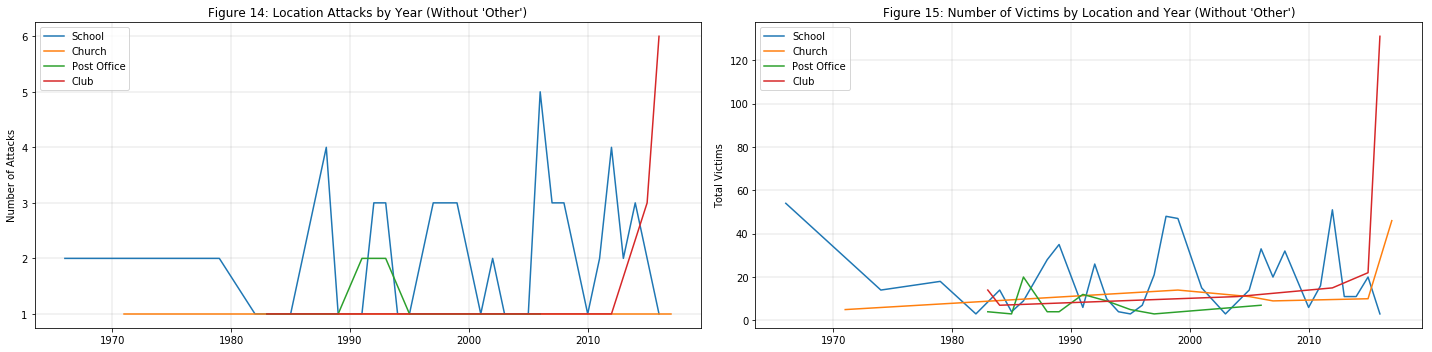

In [15]:
# plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax1.plot(school_count)
ax1.plot(church_count)
ax1.plot(postal_count)
ax1.plot(club_count)
ax1.set(xlabel='', ylabel='Number of Attacks')
dum = ax1.legend(['School', 'Church', 'Post Office', 'Club'], loc='upper left')
dum = ax1.set_title('Figure 14: Location Attacks by Year (Without \'Other\')')

ax2.plot(school_victims)
ax2.plot(church_victims)
ax2.plot(postal_victims)
ax2.plot(club_victims)
ax2.set(xlabel='', ylabel='Total Victims')
dum = ax2.legend(['School', 'Church', 'Post Office', 'Club'])
dum = ax2.set_title('Figure 15: Number of Victims by Location and Year (Without \'Other\')')

plt.tight_layout()
plt.show()

- School shooting occurances have been consistently high for all years covered in this dataset. The number of school shootings per calendar year peaked in mid-2000. 
- Post office shootings seem to be contained within a specific range of years (mid-1980 to mid-2000).
- Club shootings rose dramatically around 2012, and the number of victims in these incidents reached staggering numbers.

Having done this, let's look at school shootings and club shootings more closely.

## A Closer Look: School Shootings

In [16]:
# sort school type
conditions = [
    (school['title'].str.contains('[Uu]niversity|[Cc]ollege')),
    (school['title'].str.contains('[Ee]lementary')),
    (school['title'].str.contains('[Mm]iddle|[Jj]unior')),
    (school['title'].str.contains('[Hh]igh'))]
choices = ['Post-secondary', 'Elementary', 'Middle', 'High']
school['school_cat'] = np.select(conditions, choices, default='Other')

school_cat = school['school_cat'].value_counts()

school_age = ((pd.to_numeric(school['age'], errors='coerce')).fillna(0)).value_counts()
school_age_victims = school.groupby(['age']).sum()['v_tot']

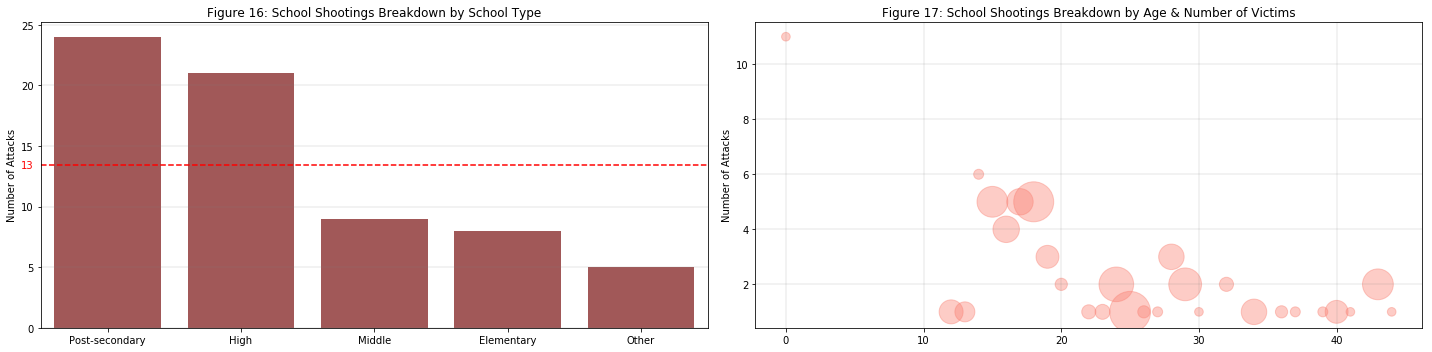

In [17]:
# plot 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax1 = sns.barplot(school_cat.index, school_cat.values, color='DarkRed', alpha=0.7, ax=ax1)
ax1.set(xlabel='', ylabel='Number of Attacks')
ax1.set_title('Figure 16: School Shootings Breakdown by School Type')
ax1.axhline(school_cat.values.mean(), linestyle='--', color='r')
trans = transforms.blended_transform_factory(ax1.get_yticklabels()[0].get_transform(), ax1.transData)
dum = ax1.text(0,school_cat.values.mean(), "{:.0f}".format(school_cat.values.mean()), color="r", transform=trans, ha="right", va="center")

ax2.scatter(school_age.index, school_age.values, s=school_age_victims*25, alpha=0.4, color='Salmon')
ax2.set(xlabel='', ylabel='Number of Attacks')
ax2.set_title('Figure 17: School Shootings Breakdown by Age & Number of Victims')

plt.tight_layout()
plt.show()

- Post-secondary institutions and high schools saw the highest number of shootings, with an average of 13 attacks across all levels of educational institutions
- Figure 17 depicts the number of attacks (y-axis) for each marker, which represents a single age category (x-axis). The size of the markers denote the relative number of combined total victims for the respective age category.
- Shooters aged approximately 14-20 seem to have initiated the most number of school shootings. There were 6 separately recorded incidents with shooters aged 14 years-old (higest record for a single age category). 
- Shooters aged 20-30 did not observe significantly high numbers of shootings, but claimed a relatively large number of victims.
- x-value of '0' denotes where 'age' was marked as 'Other' or 'null' (11 out of 67 entries; 16%).

## A Closer Look: Shooting by State

In [18]:
# fill missing lat/lon values
club['lat'].loc[club['lat'].isnull()] = 28.5383
club['lon'].loc[club['lon'].isnull()] = -81.3792

In [19]:
# sort city and state 
data['city'] = data['location'].str.rpartition(',')[0]
data['state'] = data['location'].str.rpartition(',')[2]

# examine
data['state'].sort_values().unique()

array(['  Virginia', ' Alabama', ' Alaska', ' Arizona', ' Arkansas', ' CA',
       ' CO', ' California', ' Colorado', ' Connecticut', ' Florida',
       ' Georgia', ' Hawaii', ' Idaho', ' Illinois', ' Indiana', ' Iowa',
       ' Kansas', ' Kentucky', ' LA', ' Louisiana', ' MD', ' Maine',
       ' Massachusetts', ' Michigan', ' Minnesota', ' Mississippi',
       ' Missouri', ' Montana', ' NV', ' Nebraska', ' Nevada',
       ' New Jersey', ' New Mexico', ' New York', ' North Carolina',
       ' Ohio', ' Oklahoma', ' Oregon', ' PA', ' Pennsylvania',
       ' South Carolina', ' South Dakota', ' TX', ' Tennessee', ' Texas',
       ' Texas ', ' Utah', ' Vermont', ' Virginia', ' WA', ' Washington',
       ' West Virginia', ' Wisconsin', ' Wyoming', 'Washington D.C.', nan], dtype=object)

In [20]:
# clean state data
data['state'] = data['state'].str.replace('^\s*', '')
data['state'] = data['state'].str.replace('\s$', '')
#data['state'].value_counts()

data = data.replace({'state' : {'Alabama': 'AL',
                                'Alaska': 'AK',
                                'Arizona': 'AZ',
                                'Arkansas': 'AR',
                                'California': 'CA',
                                'Colorado': 'CO',
                                'Connecticut': 'CT',
                                'Delaware': 'DE',
                                'Florida': 'FL',
                                'Georgia': 'GA',
                                'Hawaii': 'HI',
                                'Idaho': 'ID',
                                'Illinois': 'IL',
                                'Indiana': 'IN',
                                'Iowa': 'IA',
                                'Kansas': 'KS',
                                'Kentucky': 'KY',
                                'Louisiana': 'LA',
                                'Maine': 'ME',
                                'Maryland': 'MD',
                                'Massachusetts': 'MA',
                                'Michigan': 'MI',
                                'Minnesota': 'MN',
                                'Mississippi': 'MS',
                                'Missouri': 'MO',
                                'Montana': 'MT',
                                'Nebraska': 'NE',
                                'Nevada': 'NV',
                                'New Hampshire': 'NH',
                                'New Jersey': 'NJ',
                                'New Mexico': 'NM',
                                'New York': 'NY',
                                'North Carolina': 'NC',
                                'North Dakota': 'ND',
                                'Ohio': 'OH',
                                'Oklahoma': 'OK',
                                'Oregon': 'OR',
                                'Pennsylvania': 'PA',
                                'Rhode Island': 'RI',
                                'South Carolina': 'SC',
                                'South Dakota': 'SD',
                                'Tennessee': 'TN',
                                'Texas': 'TX',
                                'Utah': 'UT',
                                'Vermont': 'VT',
                                'Virginia': 'VA',
                                'Washington': 'WA',
                                'West Virginia': 'WV',
                                'Wisconsin': 'WI',
                                'Wyoming': 'WY',}})

In [21]:
# state counts
states = data['state'].value_counts()

# top states by occurances
states_occ = states.head(10)

# victim data for top states 
victims = data.groupby('state').sum()['v_tot']
t = pd.DataFrame(['CA', 'FL', 'TX', 'WA', 'GA', 'NC', 'AZ','NY', 'OH', 'PA'])
t.columns = ['state']

victims_df = pd.DataFrame(victims)
states_victims = t.join(victims_df.set_index(victims_df.index), on='state')

# states by top victim counts
victims_top = victims.sort_values(ascending=False).head(10)

# states by top victim counts - occurances
t1 = pd.DataFrame(['NV', 'CA', 'TX', 'FL', 'CO', 'WA', 'NY', 'GA', 'VA', 'IL'])
t1.columns = ['index']
states_df = pd.DataFrame(states)
victims_occ = t1.join(states_df.set_index(states_df.index), on='index')

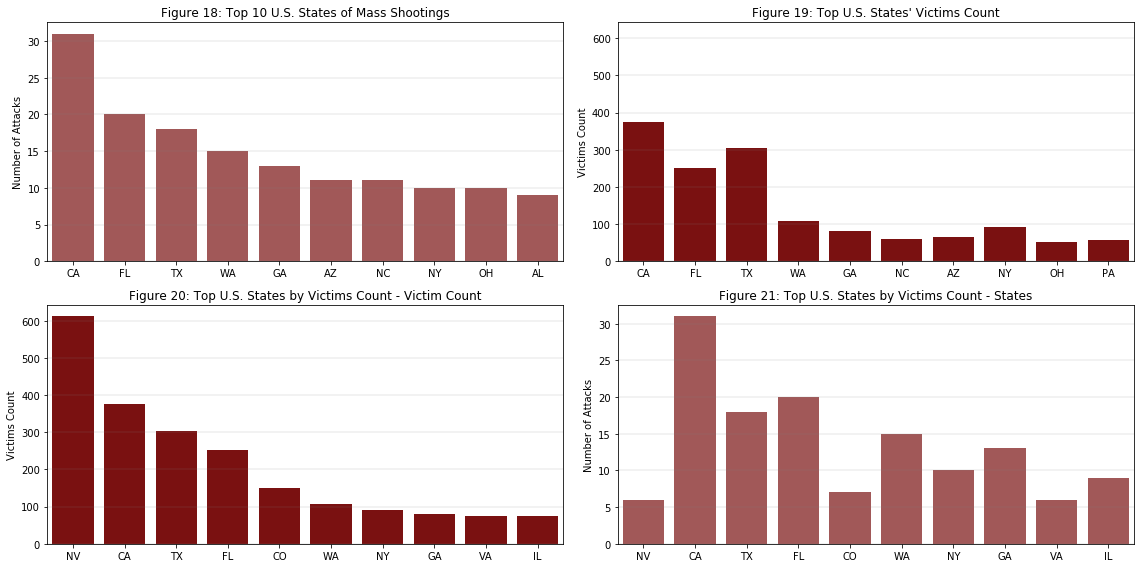

In [23]:
# plot 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.grid(color='grey', linestyle='-', linewidth=0.2)
ax1.grid(color='grey', linestyle='-', linewidth=0.2)
ax2.grid(color='grey', linestyle='-', linewidth=0.2)
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

ax0 = sns.barplot(states_occ.index, states_occ.values, color='DarkRed', alpha=0.7, ax=ax0)
ax0.set(xlabel='', ylabel='Number of Attacks')
ax0.set_title('Figure 18: Top 10 U.S. States of Mass Shootings')

ax1 = sns.barplot(states_victims['state'], states_victims['v_tot'], color='DarkRed', alpha=1, ax=ax1)
ax1.set(xlabel='', ylabel='Victims Count')
ax1.set_title('Figure 19: Top U.S. States\' Victims Count')
ax1.set_ylim([0,642.6])

ax2 = sns.barplot(victims_top.index, victims_top.values, color='DarkRed', alpha=1, ax=ax2)
ax2.set(xlabel='', ylabel='Victims Count')
ax2.set_title('Figure 20: Top U.S. States by Victims Count - Victim Count')

ax3 = sns.barplot(victims_occ['index'], victims_occ['state'], color='DarkRed', alpha=0.7, ax=ax3)
ax3.set(xlabel='', ylabel='Number of Attacks')
ax3.set_title('Figure 21: Top U.S. States by Victims Count - States')

plt.tight_layout()

- California, Florida, and Texax rank the highest in the number of attacks.
- Nevada, California, and Texas rank the highest in number of total victims (including injuries and fatalities)
- Nevada, the state with the highest victims count(612), only had 6 attacks in the dataset's recorded timeline

Going forward, it would be worth investigating the timeline of the attacks in individual states.